[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/DeepLearning/blob/main/Semana05_1_Deep_Q_Network.ipyn)

# Deep Reignforcement Learning

Problema del taxista.

El problema inicia con una cuadrícula con diferentes locaciones. En 4 de estas es posible que aparezca un pasajero. El taxi iniciará en una ubicación al azar y deberá ir hacia el pasajero para recogerlo y llevarlo a algún destino mostrado.

Este problema puede solucionarse con Q-learning, ¿Ven alguna desventaja o incoveniente que pueda tener Q-learning dado el problema descrito arriba?

En este caso, utilizaremos redes neuronales para aproximar la función dada por la tabla Q.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instalaciones necesarias

In [ ]:
!pip install keras-rl2==1.0.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 889.1 kB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attemptin

In [ ]:
!pip install gym==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.0-py3-none-any.whl size=1648674 sha256=45b022e1e2c3217e68b52036753f8482d1688e528d51a27a6f5398af932de1d6
  Stored in directory: /root/.cache/pip/wheels/2d/f2/76/f25acf56320307527b4befb1152551fb6801b925e8a3fd645a
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.18.0 requires cloudpick

In [ ]:
import numpy as np
import gym
import random

# Definición del entorno.

In [ ]:
ENV_NAME = "Taxi-v3"
env = gym.make(ENV_NAME)

env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Un episodio de este entorno comienza al generar todas las posiciones mencionadas y termina cuando el taxi entrega el pasajero (o un límite superior de pasos que se establezca)

In [ ]:
print("Número de acciones: %d" % env.action_space.n)
print("Número de estados: %d" % env.observation_space.n)

Número de acciones: 6
Número de estados: 500


¿Porqué tenemos 500 estados?

- Posición del taxi: 25 lugares disponibles
- Posición del pasajero: 5 posibilidades (?)
- Lugar de entrega: 4 posibilidades

Y vistos este estados, podemos tomar 6 acciones posibles:






0: Mover hacia abajo

1: Mover hacia arriba

2: Mover a la derecha

3: Mover a la izquierda

4: Recoger pasajero

5: Dejar pasajero

Las recompensas vistas en la trayectoria del taxi son la siguientes:

- -1 por cada acción tomada

- +20 por entregar correctamente al pasajero

- -10 de penalización por tomar acción de recoger/dejar pasajero en donde no deba

In [ ]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Los colores tienen los siguientes significados:

- azul: Ubicación del pasajero

- rosa: Destino

- amarillo: Taxi vacío

- verde: Taxi ocupado

- otras letras: Lugares

In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.n

In [ ]:
np.random.seed(123)
env.seed(123)

[123]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from keras.optimizers import Adam

Queremos crear una red neuronal que reciba como entrada el estado actual del sistema y nos regrese una acción.

Esperariamos algo del tipo:

(UbicaciónT, UbicaciónP, UbiaciónE) -----> (Acción)

(22,3,1) --------------------------------> (Acción)

In [ ]:
env.reset()
env.step(env.action_space.sample())[0]

451

Pero vemos que está codificado a una sola salida, así que podemos hacer una capa de encaje que mapea los 500 estados discretos a un vector de tamaño 6 (el de las acciones).

Si quisieramos mas capas en las redes neuronales, podemos modificar lo tamaños a algo que se crea conveniente.



# 2 Redes Neuronales a usar

In [ ]:
model_only_embedding = Sequential()
model_only_embedding.add(Embedding(500, 6, input_length=1))
model_only_embedding.add(Reshape((6,)))
print(model_only_embedding.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 6)              3000      
                                                                 
 reshape_3 (Reshape)         (None, 6)                 0         
                                                                 
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model = Sequential()
model.add(Embedding(500, 10, input_length=1))
model.add(Reshape((10,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 10)             5000      
                                                                 
 reshape_4 (Reshape)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                550       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 10,956
Trainable params: 10,956
Non-trai

# Estructura General

![1_ibWj_Ym7JWhz551PrHTUkA[1].png](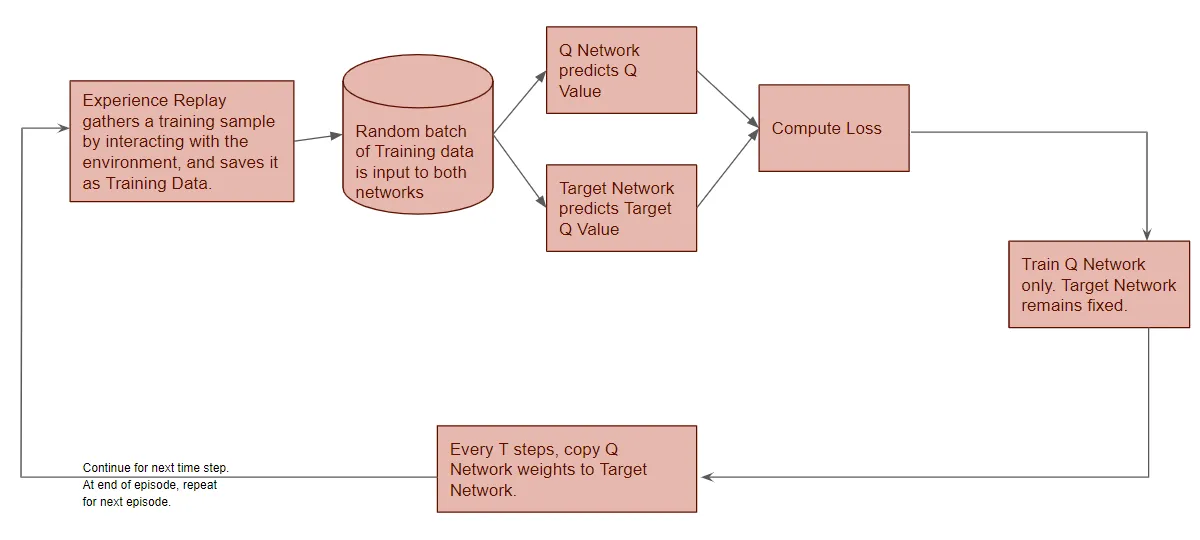)


# Entrenamiento de los modelos

Parámetros utilizados:

En el objeto "SequentialMemory":
- limit: Cantidad de (estado, accion, recompensa, nuevo estado) que guarda el agente en su memoria
- window_length: Cantidad de estados vistos hacía atras para tomar decisión

En DQNAgent:
- nb_sets_warmup: Cantidad de episodios en que tomará acciones al azar
-target_model_update: Cada cuanto se cambiarán los parámetros de la Red Neuronal objetivo (porcentual)

En método fit:
- nb_steps: Todos los pasos totales que hará el agente
- nb_max_episode_steps: Cantidad de pasos máximos que daráel agente en un episodio


In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

#memory = SequentialMemory(limit=50000, window_length=1)
#policy = EpsGreedyQPolicy()
#dqn_only_embedding = DQNAgent(model=model_only_embedding, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
#dqn_only_embedding.compile(Adam(learning_rate=1e-3), metrics=['mae'])
#dqn_only_embedding.fit(env, nb_steps=1000000, visualize=False, verbose=1, nb_max_episode_steps=99, log_interval=100000)

Salida de la celda anterior (por si llega a borrarse la sálida)

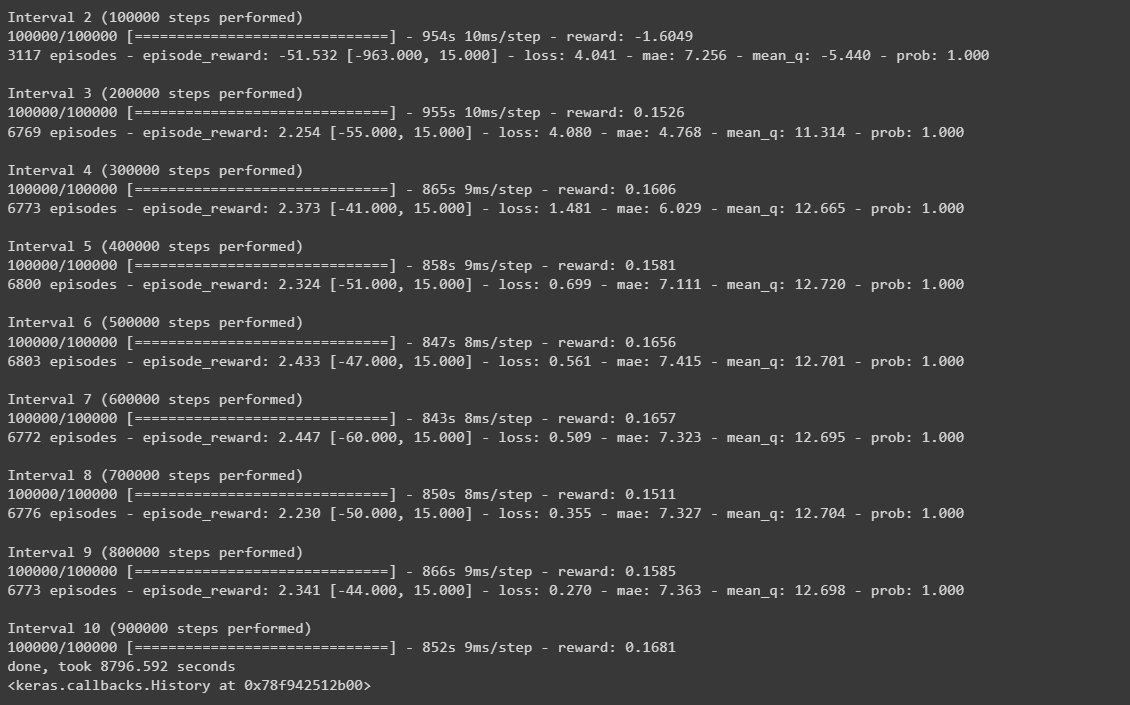

Parámetros:



In [ ]:
# Esta celda funciona directamente cuando se entrena la red neuronal

#dqn_only_embedding.test(env, nb_episodes=2, visualize=True, nb_max_episode_steps=99)

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn_only_embedding = DQNAgent(model=model_only_embedding, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
dqn_only_embedding.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
#dqn_only_embedding.save_weights('/content/drive/MyDrive/Curso-DeepLearning/Semana6/taxi_render/dqn_{}_weights_embedding.h5f'.format("Taxi-v2"), overwrite=True)

In [ ]:
#dqn_only_embedding.load_weights("/content/drive/MyDrive/Curso-DeepLearning/Semana6/taxi_render/dqn_Taxi-v2_weights_embedding.h5f")

In [ ]:
dqn_only_embedding.test(env, nb_episodes=2, visualize=True, nb_max_episode_steps=99)

Testing for 2 episodes ...
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| 

In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

#memory = SequentialMemory(limit=50000, window_length=1)
#policy = EpsGreedyQPolicy()
#dqn = DQNAgent(model=model, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])
#dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1, nb_max_episode_steps=99, log_interval=100000)

Salida de las celdas anteriores (por si se llegan a borrar)

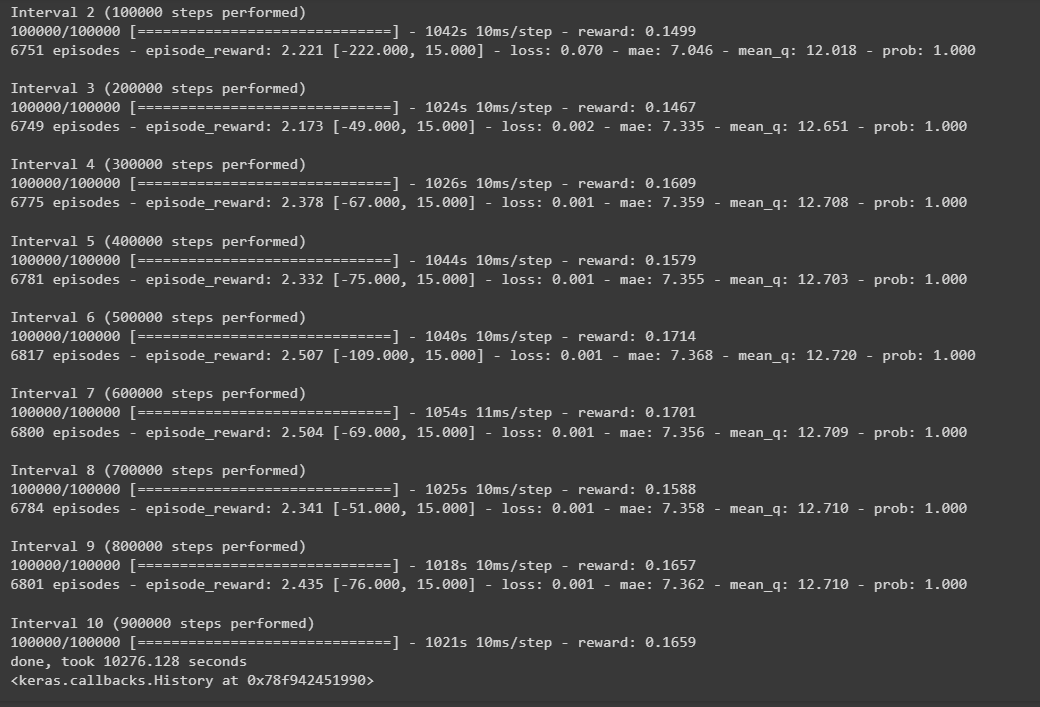

In [ ]:
dqn.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=99)

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
#dqn.save_weights("/content/drive/MyDrive/Curso-DeepLearning/Semana6/taxi_render/dqn_Taxi-v2_weights.h5f")

In [ ]:
dqn.load_weights("/content/drive/MyDrive/Curso-DeepLearning/Semana6/taxi_render/dqn_Taxi-v2_weights.h5f")

In [ ]:
dqn.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=99)

Testing for 5 episodes ...
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |

# Referencias

- https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b
- https://tiewkh.github.io/blog/deepqlearning-openaitaxi/
